In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import model_selection
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.externals.six import StringIO
import pydot
from IPython.display import Image
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
%matplotlib inline

# Problem 2 
## Decision Tree to Predict Census Income

## (a) Pre-processing

In [3]:
names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','label']
adult_data = pd.read_csv('adult.data',header=None, names=names,skipinitialspace =True)
test_data = pd.read_csv('adult.test',header=None, names=names,skipinitialspace =True)
test_data = test_data.dropna()
test_data['label'] = test_data['label'].str.rsplit('.',expand=True)[0]
adult_data = adult_data.append(test_data,ignore_index=True)
# let's drop education name because they can be defined as education-num
adult_data.drop(adult_data.columns[[3]], axis=1, inplace=True)
adult_data.shape

(48842, 14)

In [4]:
# fill missing data among the continuous data, though I did not find any continuous data is missing.
for item in ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']:
    x,y = adult_data.loc[adult_data[item].isnull()].shape
    if x > 0:
        temp_mean = adult_data[item].mean()
        adult_data[item].fillna(temp_mean)

#### Because DecisionTreeClassifier in sklearn can only receive inputs of numbers, the categorical values need to be transfered as dummies values.

In [5]:
dummies = {} 
for item in ['workclass','marital-status','occupation','relationship','race','sex','native-country','label']:
    miss_index = (adult_data.loc[adult_data[item].str.find('?') != -1].index.tolist())
    temp_dummy = None
    if len(miss_index) > 0:
        temp_dummy = pd.get_dummies(adult_data[item], prefix=item).iloc[:, 1:] #drop additional column '?'
        max_mode_index = np.argmax(temp_dummy.sum())
        for mi in miss_index:
            temp_dummy.set_value(mi,max_mode_index,1)
        temp_dummy.drop(temp_dummy.columns[[0]], axis=1, inplace=True)#drop one feature which can be represented by all zeros
    else:
        temp_dummy = pd.get_dummies(adult_data[item], prefix=item).iloc[:, 1:] #drop additional column represented by all zeros
    dummies[item] = temp_dummy

In [6]:
# concatenate the dummy variables and drop the duplicates
for key,value in dummies.items():
    if key != 'label':
        adult_data.drop(key, axis=1, inplace=True)
        adult_data = pd.concat([adult_data, value], axis=1)
adult_data.drop('label', axis=1, inplace=True)
adult_data = pd.concat([adult_data, dummies['label']], axis=1)
adult_y = adult_data['label_>50K'].values
adult_data.drop('label_>50K',axis=1, inplace=True)

### because the size of this train data set is large enough, 
### I set the rate of train-test as 2:1 

In [7]:
trainX, testX, trainY, testY = model_selection.train_test_split(adult_data, adult_y, test_size=1.0/3, random_state=5)

## (b) Max_depth and Min_samples_leaf

In [11]:
clf = tree.DecisionTreeClassifier()
x_index = range(1,51)
y_index = range(1,31)
X,Y = np.meshgrid(x_index,y_index)
scores = np.zeros(X.shape)
for j in x_index: # min_samples_leaf = j    
    for k in y_index: # max_depth = k
        clf.set_params(max_depth=k,min_samples_leaf=j)
        scores[k-1][j-1] = cross_val_score(clf, trainX, trainY, scoring='accuracy', cv=5).mean()

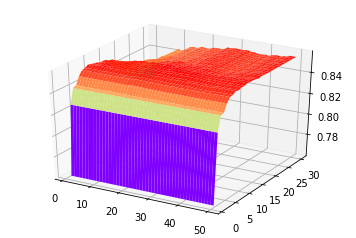

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,scores,rstride=1, cstride=1, cmap='rainbow')

In [16]:
max_y = np.argmax(np.max(scores,axis=1))+1
max_x = np.argmax(np.max(scores,axis=0))+1
print 'Optimal Choices of parameters:'
print 'max_depth\t','min_samples_leaf'
print max_y,'\t\t\t',max_x

Optimal Choices of parameters:
max_depth	min_samples_leaf
13 			22


## (c) Performance on the test set

In [17]:
clf.set_params(max_depth=max_y,min_samples_leaf=max_x)
clf.fit(trainX, trainY)
test_score = clf.score(testX,testY)
print 'test_score with optimal parameters'
print test_score

test_score with optimal parameters
0.857441189116


## (d) Visualization of the top 3 levels of the D-tree

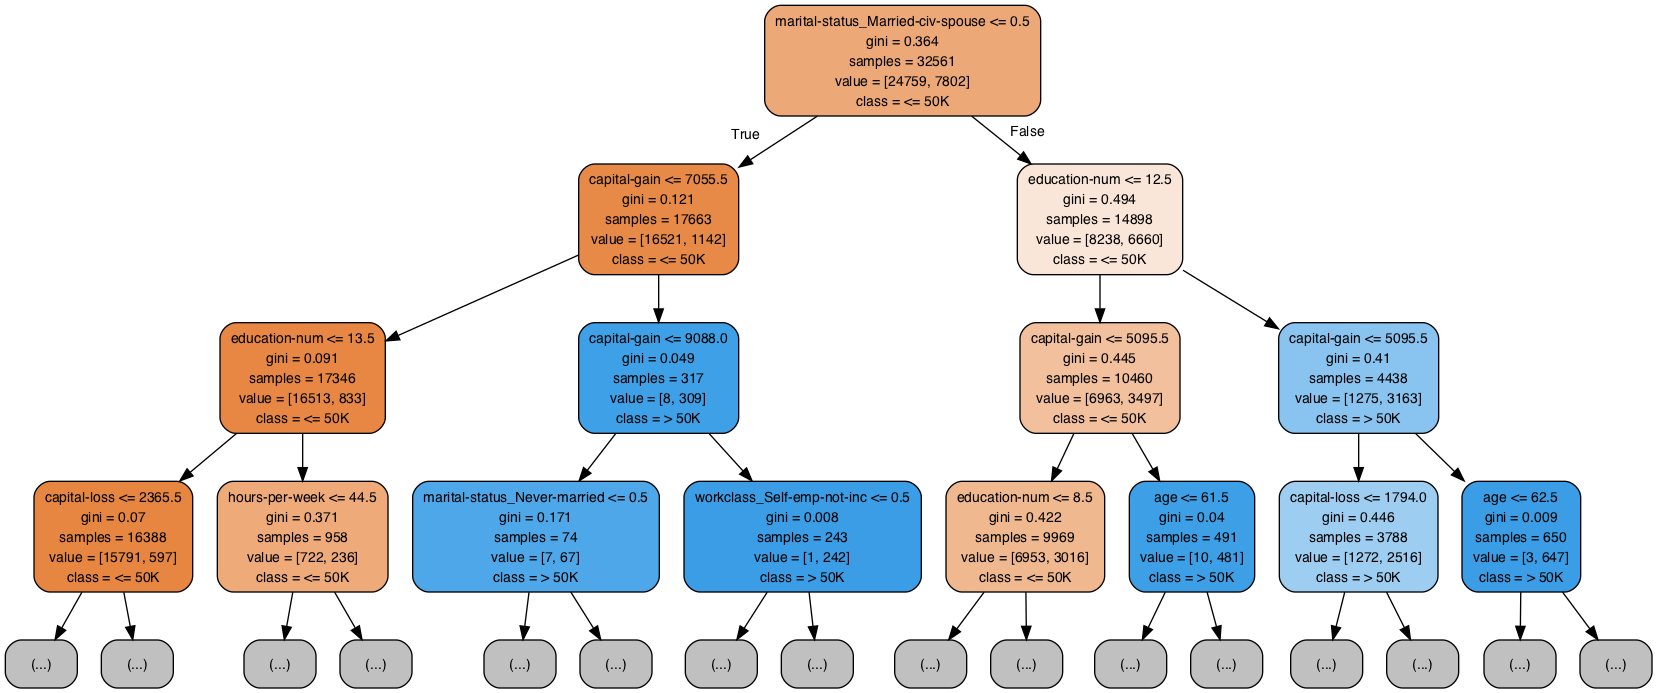

In [18]:
dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,max_depth=3,feature_names=adult_data.columns,class_names=['<= 50K',"> 50K"],rounded=True,filled=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())  

# Problem 3 Gradient Boosting to Predict Blog Feedback

In [2]:
train_data = pd.read_csv('blogData_train.csv', header=None)
validate_data = pd.read_csv('blogData_validate.csv',  header=None)
test_data = pd.read_csv('blogData_test.csv',  header=None)

train_X = train_data.as_matrix(range(280))
validate_X = validate_data.as_matrix(range(280))
test_X = test_data.as_matrix(range(280))

train_Y = np.ravel(train_data.as_matrix([280]))
validate_Y = np.ravel(validate_data.as_matrix([280]))
test_Y = np.ravel(test_data.as_matrix([280]))

scaler = preprocessing.MinMaxScaler()
print(scaler.fit(train_X))

train_X = scaler.transform(train_X)
validate_X = scaler.transform(validate_X)
test_X = scaler.transform(test_X)


MinMaxScaler(copy=True, feature_range=(0, 1))


## (a) Implement Gradient Boosting

In [36]:
# function of calculate Gradient Boosting
def GBS_mse(x, y, x2, y2, M, v):
    reg = tree.DecisionTreeRegressor(criterion='mse',max_depth = 20,min_samples_leaf=20)
    f = np.ones(len(y))*np.mean(y) # initial f0
    f2 = np.ones(len(y2))*np.mean(y2) 
    err = []
    for m in range(M):
        r = (y-f)
        reg.fit(x,r)
        h = reg.predict(x)
        h2 = reg.predict(x2)
        f = f + v*h
        f2 = f2 + v*h2
        if (m+1) % 5 == 0:
            err.append(metrics.mean_squared_error(y2,f2))
    return err

def GBS_mae(x, y, x2, y2, M, v):
    reg = tree.DecisionTreeRegressor(criterion='mse',max_depth = 20,min_samples_leaf=20)
    f = np.ones(len(y))*np.mean(y) # initial f0
    f2 = np.ones(len(y2))*np.mean(y2) 
    err = []
    for m in range(M):
        r = np.sign((y-f))
        reg.fit(x,r)
        h = reg.predict(x)
        h2 = reg.predict(x2)
        f = f + v*h
        f2 = f2 + v*h2
        if (m+1) % 5 == 0:
            err.append(metrics.mean_absolute_error(y2,f2))
    return err

In [8]:
m = 25
v = 0.1

f_mse = GBS_mse(train_X, train_Y, validate_X, validate_Y, m,v)
f_mae = GBS_mae(train_X, train_Y, validate_X, validate_Y, m,v)

print 'on validate set (v = 0.1)'
table_a = pd.DataFrame(data=[f_mse,f_mae], index=['MSE','MAE'], columns=['nIter=5','nIter=10','nIter=15','nIter=20','nIter=25'])
table_a.head()

on validate set (v = 0.1)


,nIter=5,nIter=10,nIter=15,nIter=20,nIter=25
MSE,753.452293,632.170568,580.031906,561.109836,550.498608
MAE,9.200012,8.794214,8.397229,8.004901,7.619146


## (b) Number of boosting iteration and Shrinkage parameter

In [37]:
M = 25
V = np.linspace(0,1,11)

mse_arr = []
mae_arr = []
for v in V:
    temp_mse_err = GBS_mse(train_X, train_Y, validate_X, validate_Y, M,v)
    temp_mae_err = GBS_mae(train_X, train_Y, validate_X, validate_Y, M,v)
    mse_arr.append(temp_mse_err)
    mae_arr.append(temp_mae_err)

mse_arr = np.array(mse_arr)
mae_arr = np.array(mae_arr)
# delete column nIter = 20
mse_arr = np.delete(mse_arr,3,1)
mae_arr = np.delete(mae_arr,3,1)
    

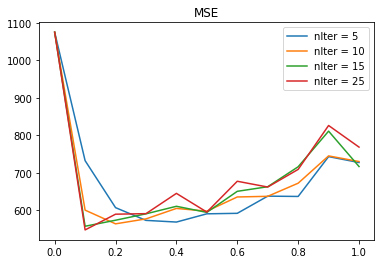

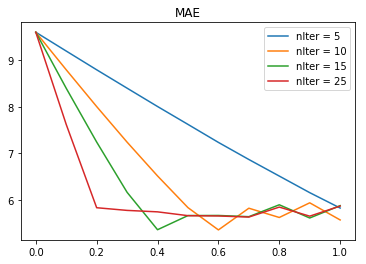

In [38]:
plt.figure(1)

plt.plot(V,np.ravel(mse_arr[:,0]),label='nIter = 5')
plt.plot(V,np.ravel(mse_arr[:,1]),label='nIter = 10')
plt.plot(V,np.ravel(mse_arr[:,2]),label='nIter = 15')
plt.plot(V,np.ravel(mse_arr[:,3]),label='nIter = 25')
plt.title('MSE')
plt.legend()
plt.show()

plt.plot(V,np.ravel(mae_arr[:,0]),label='nIter = 5')
plt.plot(V,np.ravel(mae_arr[:,1]),label='nIter = 10')
plt.plot(V,np.ravel(mae_arr[:,2]),label='nIter = 15')
plt.plot(V,np.ravel(mae_arr[:,3]),label='nIter = 25')
plt.title('MAE')
plt.legend()
plt.show()

### Conlusion

(1) Comparing the validation errors for MSE and MAE, we can see that the convergence speed of MSE is faster than that of MAE such that the optimal shrinkage of MSE is smaller than that of MAE. I think this is because the step of each gradient in MSE depends on (y-f), while the step of each gradient in MAE has been constrained by one pace (without shrinkage) such that the learning speed of MAE is smaller than that of MSE. 

(2) Looking at the parameter nIter, there are some difference between MSE and MAE. 

For MSE, given fixed small shrinkage v, we can see that the models with small nIter have higher validation error than the models with large nIter and vise versa. I think this is because smaller v have better shrinkage performance.

For MAE, when the nIter is small, the model cannot achieve good performance because its low learning speed(see the curve as nIter = 5). But when nIter is too large, the model cannot achieve good performance maybe because it overfit in train set. So the optimal value of nIter in MAE is 10 here.

(3) Looking at the shrinkage v, given fixed nIter, we can see that the validation errors decrease as the shrinkage v increase from 0, but it begins to increase when the shrinkage v reach to a certain value. It is obvious that if v = 0, there is no gradient boosting such that validation errors are high. And if v = 1, there is no shrinkage on gradient boosting such that the influence of a new classifier is too large such that the model cannot obtain a better performance. However, the particular case of MAE with nIter = 5 does not show this property. I think this is because the model with MAE Gradient boosting does not achieve optimal result after 5 iteration of Gradient boosting.

(4) According to the analysis in (2) and (3), we can conclude that the nIter and the shrinkage are complementary which means the smaller shrinkage v requires the larger nIter to obtain the better performance. Therefore, to achieve a tradeoff to obtain a better performance, we can use a larger shrinkage with smaller nIter, or use a smaller shrinkage with larger nIter. The chioce of these two cases depends on the loss function and the data.

## (c)

In [39]:
nIters = [5,10,15,25]
m_min_mse = nIters[np.argmin(mse_arr)%4]
v_min_mse = V[np.argmin(mse_arr)/5]

m_min_mae = nIters[np.argmin(mae_arr)%4]
v_min_mae = V[np.argmin(mae_arr)/5]

In [40]:
M = 25
V = np.linspace(0,1,11)

test_mse_arr = []
test_mae_arr = []
for v in V:
    temp_mse_err = GBS_mse(train_X, train_Y, test_X, test_Y, M,v)
    temp_mae_err = GBS_mae(train_X, train_Y, test_X, test_Y, M,v)
    test_mse_arr.append(temp_mse_err)
    test_mae_arr.append(temp_mae_err)

test_mse_arr = np.array(test_mse_arr)
test_mae_arr = np.array(test_mae_arr)
# delete column nIter = 20
test_mse_arr = np.delete(test_mse_arr,3,1)
test_mae_arr = np.delete(test_mae_arr,3,1)

In [41]:
f_mse = GBS_mse(train_X, train_Y, test_X, test_Y, m_min_mse,v_min_mse)[-1]
f_mae = GBS_mae(train_X, train_Y, test_X, test_Y, m_min_mae,v_min_mae)[-1]


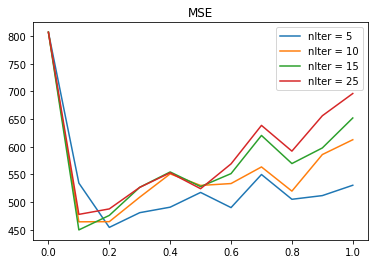

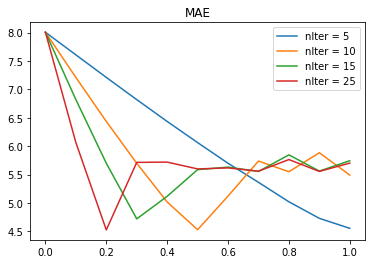

on test set 
MSE(v_max_valid =  0.1 ,nIter_max_valid =  25 ) : 	476.066011849
MAE(v_max_valid =  0.5 ,nIter_max_valid =  10 ) : 	4.52752796832


In [42]:
plt.figure(1)

plt.plot(V,np.ravel(test_mse_arr[:,0]),label='nIter = 5')
plt.plot(V,np.ravel(test_mse_arr[:,1]),label='nIter = 10')
plt.plot(V,np.ravel(test_mse_arr[:,2]),label='nIter = 15')
plt.plot(V,np.ravel(test_mse_arr[:,3]),label='nIter = 25')
plt.title('MSE')
plt.legend()
plt.show()

plt.plot(V,np.ravel(test_mae_arr[:,0]),label='nIter = 5')
plt.plot(V,np.ravel(test_mae_arr[:,1]),label='nIter = 10')
plt.plot(V,np.ravel(test_mae_arr[:,2]),label='nIter = 15')
plt.plot(V,np.ravel(test_mae_arr[:,3]),label='nIter = 25')
plt.title('MAE')
plt.legend()
plt.show()


print 'on test set '
print 'MSE(v_max_valid = ',v_min_mse, ',nIter_max_valid = ',m_min_mse,') : \t', f_mse
print 'MAE(v_max_valid = ',v_min_mae, ',nIter_max_valid = ',m_min_mae,') : \t', f_mae

### Conclusion

As you can see in the above graph, although the model with optimal parameter in validation set cannont achieve best performance in test set because the two data set are different and the model is not too robust, it still achieve good enough performance in test set. Moreover, at the same nIter, the shrinkage v of the lowest rate in test set is the same as the shrinkage v of the lowest rate in validation set.